# Autoencoder

 A CCN based autoencoder.

 Steps:

 1. build an autoencoder
 2. cluster code

## Load dataset

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [39]:
random.seed(42)
np.random.seed(42)

In [40]:
def load_dataset():
    data = pd.read_csv("./datasets/our2/dataset_50_2.5.csv", header=None, names=range(750))
    labels = pd.read_csv("./datasets/our2/dataset_labels_50_2.5.csv", header=None, names=["user", "model", "label"])

    return data, labels

In [41]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [42]:
X_df_reference, y_df_reference = load_dataset()

In [43]:
print_stats(X_df_reference)
print_stats(y_df_reference)

Shape (22589, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (22589, 3)
Columns Index(['user', 'model', 'label'], dtype='object')


## Preprocessing

In [44]:
def get_label(x):
    return x[2]

In [45]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [46]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

Preoprocess the dataset with the following steps:

1. From pandas dataframe to numpy arrays
2. Restructure plain data vector from (750,) to (6,125) where first 3 vectors are accelerometer's x, y, z components while second 3 vectors are gyroscope's x, y, z components
3. Merge labels if needed
4. Normalize data
5. Split the dataset in train and test set
6. Disregard useless informations in y

In [47]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

In [48]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
but_last_user_indicies = y_df['user'] < "h"

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 17478
X_test_df = 5111
y_train_df = 17478
y_test_df = 5111


In [49]:
# 1. Back to numpy
X_train = X_train_df.loc[:].to_numpy()
X_test = X_test_df.loc[:].to_numpy()
X_train_oit = orientation_independent_transformation(np.reshape(X_train, (-1, 6, 125)))
X_test_oit = orientation_independent_transformation(np.reshape(X_test, (-1, 6, 125)))

y_train = y_train_df.loc[:].to_numpy()
y_test = y_test_df.loc[:].to_numpy()
y_train_hot = pd.get_dummies(y_train_df['label']).to_numpy()
y_test_hot = pd.get_dummies(y_test_df['label']).to_numpy()


# 2. Restructure the array
X_train = restructure(X_train)
X_test = restructure(X_test)

# 3. Normalize
# NB: we do not normalize beacause the distance between points and reconstructed points
# is reduced but the signal is not well represented
#X_train = normalize(X_train)
#X_test = normalize(X_test)

# 5. Keep only label
y_train = np.array(list(map(get_label, y_train)))
y_test = np.array(list(map(get_label, y_test)))

: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enc

In [50]:
print(X_train.shape)
print(y_train.shape)

(17478, 6, 125)
(17478,)


Labels

In [51]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes 5


In [52]:
assert X_train.shape == (y_train.shape[0], 6, 125), f"Invalid shape of X_train: {X_train.shape}"
assert y_train.shape == (X_train.shape[0],), f"Invalid shape of y_train: {y_train.shape}"
assert X_test.shape == (y_test.shape[0], 6, 125), f"Invalid shape of X_test: {X_test.shape}"
assert y_test.shape == (X_test.shape[0],), f"Invalid shape of y_test: {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

Plot some samples

X[0]: bike


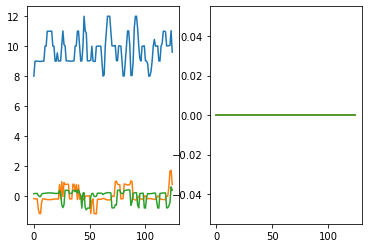

In [53]:
show_samples(X_train_oit, y_train, n=1, is_random=False)

## Data Exploration

In [54]:
print("Users", y_df["user"].unique())
print("Models", y_df["model"].unique())
print("Classes", y_df["label"].unique())

Users ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i']
Models ['nexus4_1' 'nexus4_2' 's3_1' 's3_2' 's3mini_1' 's3mini_2']
Classes ['no_activity' 'walk' 'stairsup' 'stairsdown' 'bike']


Fraction of samples per label

In [55]:
print(y_df.groupby(["label"])["label"].count() / y_df["label"].count())

label
bike           0.139714
no_activity    0.368941
stairsdown     0.118155
stairsup       0.151445
walk           0.221745
Name: label, dtype: float64


Fraction of samples per user

In [56]:
print(y_df.groupby(["user"])["user"].count() / y_df["user"].count())

user
a    0.113949
b    0.115366
c    0.101465
d    0.114480
e    0.120413
f    0.094781
g    0.113285
h    0.107353
i    0.118907
Name: user, dtype: float64


Fraction of samples per model

In [57]:
print(y_df.groupby(["model"])["model"].count() / y_df["model"].count())

model
nexus4_1    0.198105
nexus4_2    0.211342
s3_1        0.187171
s3_2        0.206029
s3mini_1    0.190137
s3mini_2    0.007216
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [58]:
y_df_i = y_df.loc[y_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

2686
label
bike           0.164557
no_activity    0.380491
stairsdown     0.119509
stairsup       0.099032
walk           0.236411
Name: label, dtype: float64


## Model (autoencoder)

X[0]: bike


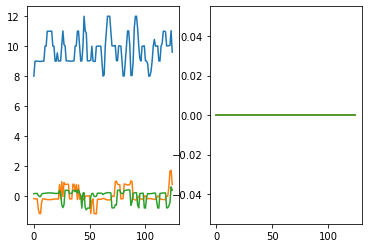

In [59]:
show_samples(X_train_oit, y_train, n=1, is_random=False)

In [60]:
DATA_SHAPE = X_train_oit.shape[1:]
CODE_SIZE=72

In [61]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)
    X = layers.Flatten()(inputs)
    outputs = layers.Dense(code_size, activation="sigmoid")(X)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [62]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))
    X = layers.Dense(np.prod(data_shape), activation=None)(inputs)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [63]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [64]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [65]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=100
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
save_model_checkpoint_callback = ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train_oit, y=X_train_oit, 
    epochs=epochs, 
    validation_data=(X_test_oit, X_test_oit), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/100
137/137 [==============================] - 0s 3ms/step - loss: 6.9813 - val_loss: 2.2775
Epoch 2/100
137/137 [==============================] - 0s 3ms/step - loss: 1.7757 - val_loss: 1.4370
Epoch 3/100
137/137 [==============================] - 0s 2ms/step - loss: 1.5354 - val_loss: 1.2942
Epoch 4/100
137/137 [==============================] - 0s 2ms/step - loss: 1.4260 - val_loss: 1.1852
Epoch 5/100
137/137 [==============================] - 0s 2ms/step - loss: 1.3431 - val_loss: 1.1132
Epoch 6/100
137/137 [==============================] - 0s 2ms/step - loss: 1.2525 - val_loss: 1.0465
Epoch 7/100
137/137 [==============================] - 0s 2ms/step - loss: 1.1903 - val_loss: 1.0096
Epoch 8/100
137/137 [==============================] - 0s 2ms/step - loss: 1.1518 - val_loss: 0.9817
Epoch 9/100
137/137 [==============================] - 0s 2ms/step - loss: 1.1229 - val_loss: 0.9666
Epoch 10/100
137/137 [==============================] - 0s 2ms/step - loss: 1.0998 - val_lo

In [75]:
encoder.save("encoder.h5")

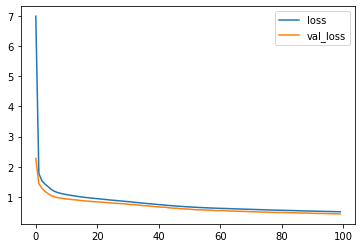

In [66]:
show_loss(history)

In [67]:
show_mse(autoencoder, X_test_oit)

MSE = 0.4405708312988281


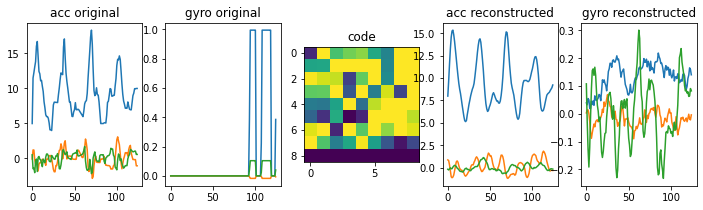

In [68]:
show_reconstructed_signals(X_test_oit, encoder, decoder, n=1)

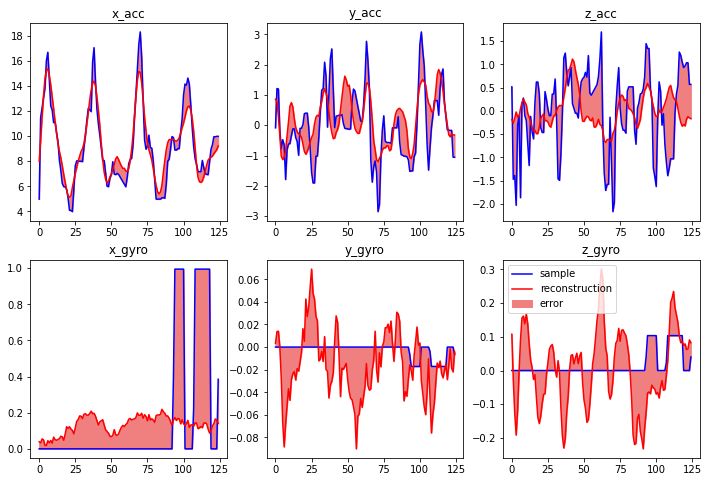

In [69]:
show_reconstruction_errors(X_test_oit, encoder, decoder, n=1)

Evaluate model by clustering features

In [70]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes = encoder.predict(X_train_oit)

assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"

# create the k-neighbors calssifier
n_neighbors = num_classes
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

KNeighborsClassifier(metric='euclidean')

In [71]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']


In [72]:
print("X_test_oit[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    x = X_test_oit[i]
    y = y_test[i]

    c = encoder.predict(x[np.newaxis, :])[0]
    
    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")


X_test_oit[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = stairsdown	 stairsdown   	 with probs [0.  0.  0.6 0.4 0. ]
X_test[1] = stairsup	 stairsup   	 with probs [0. 0. 0. 1. 0.]
X_test[2] = bike	 no_activity   	 with probs [0.2 0.8 0.  0.  0. ]
X_test[3] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[4] = bike	 bike   	 with probs [0.8 0.2 0.  0.  0. ]
X_test[5] = walk	 walk   	 with probs [0.  0.  0.2 0.2 0.6]
X_test[6] = stairsdown	 stairsdown   	 with probs [0.2 0.  0.4 0.4 0. ]
X_test[7] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[8] = bike	 no_activity   	 with probs [0.2 0.8 0.  0.  0. ]
X_test[9] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[10] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[11] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[12] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[13] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0

In [73]:
from sklearn.metrics import classification_report

codes = encoder.predict(X_test_oit)

y_true = y_test
y_pred = nbrs.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.53      0.54      0.53       819
 no_activity       0.78      1.00      0.88      1950
  stairsdown       0.82      0.49      0.61       613
    stairsup       0.39      0.29      0.33       623
        walk       0.90      0.76      0.82      1106

    accuracy                           0.73      5111
   macro avg       0.68      0.62      0.64      5111
weighted avg       0.72      0.73      0.71      5111



In [74]:
raise 1

TypeError: exceptions must derive from BaseException

## Model (acc/gyro data splitted)

In [76]:
def split_acc_gyro(data):
    acc_data = np.array(list(map(lambda x: x[:3], data)))
    gyro_data = np.array(list(map(lambda x: x[3:], data)))

    assert len(data) == len(acc_data) == len(gyro_data)

    return acc_data, gyro_data

def merge_acc_gyro(acc_data, gyro_data):
    return np.array(list(map(lambda x: np.append(x[0], x[1]), zip(acc_data, gyro_data))))

In [77]:
X_train_acc, X_train_gyro = split_acc_gyro(X_train_oit)
X_test_acc, X_test_gyro = split_acc_gyro(X_test_oit)

print("X_train_acc.shape =", X_train_acc.shape)
print("X_test_acc.shape =", X_test_acc.shape)
print("X_train_gyro.shape =", X_train_gyro.shape)
print("X_test_gyro.shape =", X_test_gyro.shape)

X_train_acc.shape = (17478, 3, 125)
X_test_acc.shape = (5111, 3, 125)
X_train_gyro.shape = (17478, 3, 125)
X_test_gyro.shape = (5111, 3, 125)


In [78]:
DATA_SHAPE = X_train_acc.shape[1:]
CODE_SIZE_ACC = 72
CODE_SIZE_GYRO = 18

In [79]:
optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=50
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
save_model_checkpoint_callback = ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

In [80]:
encoder_acc = build_encoder(DATA_SHAPE, CODE_SIZE_ACC)
decoder_acc = build_decoder(DATA_SHAPE, CODE_SIZE_ACC)

autoencoder_acc = build_autoencoder(encoder_acc, decoder_acc)

autoencoder_acc.compile(optimizer=optimizer, loss=loss)

history = autoencoder_acc.fit(
    x=X_train_acc, y=X_train_acc, 
    epochs=epochs, 
    validation_data=(X_test_acc, X_test_acc), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/50
137/137 [==============================] - 0s 3ms/step - loss: 14.5636 - val_loss: 4.5917
Epoch 2/50
137/137 [==============================] - 0s 2ms/step - loss: 3.4846 - val_loss: 2.7706
Epoch 3/50
137/137 [==============================] - 0s 2ms/step - loss: 2.9891 - val_loss: 2.4939
Epoch 4/50
137/137 [==============================] - 0s 2ms/step - loss: 2.8424 - val_loss: 2.3334
Epoch 5/50
137/137 [==============================] - 0s 2ms/step - loss: 2.6700 - val_loss: 2.1882
Epoch 6/50
137/137 [==============================] - 0s 2ms/step - loss: 2.5307 - val_loss: 2.0854
Epoch 7/50
137/137 [==============================] - 0s 2ms/step - loss: 2.4345 - val_loss: 2.0109
Epoch 8/50
137/137 [==============================] - 0s 2ms/step - loss: 2.3417 - val_loss: 1.9581
Epoch 9/50
137/137 [==============================] - 0s 2ms/step - loss: 2.2714 - val_loss: 1.9210
Epoch 10/50
137/137 [==============================] - 0s 2ms/step - loss: 2.2158 - val_loss: 1.881

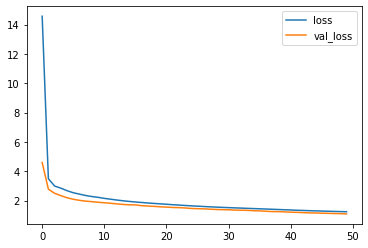

In [82]:
show_loss(history)

Merge encoder in class

In [83]:
loss_acc = autoencoder_acc.evaluate(X_test_acc, X_test_acc, verbose=0)
print("MSE ACC:", loss_acc)

MSE ACC: 1.0856467485427856


In [759]:
#for i in range(10):
#    sample_acc = X_test_acc[i]
#    sample_gyro = X_test_gyro[i]
#
#    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
#    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]
#
#    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
#    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]
#    
#    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
#    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
#    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))
#
#    plt.figure(figsize=(12,3))
#    visualize(sample=sample, code=code, reconstruction=reconstruction)
#    plt.show()

In [760]:
# reconstruction error, temporary commented out

#for i in range(10):
#    sample_acc = X_test_acc[i]
#    sample_gyro = X_test_gyro[i]
#
#    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
#    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]
#
#    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
#    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]
#    
#    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
#    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
#    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))
#
#    plt.figure(figsize=(12,8))
#    plot_reconstruction_error(sample, reconstruction)
#    plt.show()

We apply a lowpass filter to reconstructed signal to avoid oscillations

In [84]:
from scipy.signal import butter, filtfilt, freqz
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [85]:
def plot_butter_lowpass_filter(cutoff, fs, order):
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()


Setting the filter parameters and plotting it

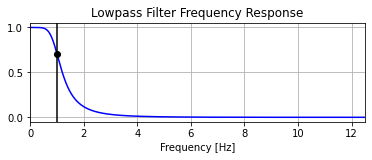

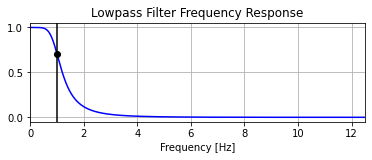

In [86]:
cutoff_acc = 1  # desired cutoff frequency of the filter, Hz
fs_acc = 25      # sample rate, Hz
order_acc = 3

cutoff_gyro = 1  # desired cutoff frequency of the filter, Hz
fs_gyro = 25     # sample rate, Hz
order_gyro = 3

plot_butter_lowpass_filter(cutoff_acc, fs_acc, order_acc)
plt.show()
plot_butter_lowpass_filter(cutoff_gyro, fs_gyro, order_gyro)
plt.show()

Show some examples of reconstructed and filtered signals

In [87]:
#for i in range(1):
#    sample_acc = X_test_acc[i]
#    sample_gyro = X_test_gyro[i]
#
#    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
#    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]
#
#    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
#    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]
#
#    reconstruction_acc_filtered = np.array(list(map(lambda x: butter_lowpass_filter(x, cutoff_acc, fs_acc, order_acc), #reconstruction_acc)))
#    reconstruction_gyro_filtered = np.array(list(map(lambda x: butter_lowpass_filter(x, cutoff_gyro, fs_gyro, order_gyro), #reconstruction_gyro)))
#    
#    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
#    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
#    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))
#    reconstruction_filtered = np.append(reconstruction_acc_filtered, reconstruction_gyro_filtered).reshape((6,125))
#
#    print(f"X_test[{i}] = {y_test[i]}")
#
#    plt.figure(figsize=(12,3))
#    visualize(sample=sample, code=code, reconstruction=reconstruction)
#    plt.show()
#
#    plt.figure(figsize=(12,3))
#    visualize(sample=sample, code=code, reconstruction=reconstruction_filtered)
#    plt.show()

How to evaluate the autoencoder now?

In [88]:
# We need to evaluate the autoencoder on the filtered reconstructed signal

#reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
#print("Convolutional autoencoder MSE:", reconstruction_mse)

## Clustering

In [89]:
#from sklearn.neighbors import KNeighborsClassifier
#
## prepare the codes
#codes_acc = encoder_acc.predict(X_train_acc)
#codes_gyro = encoder_gyro.predict(X_train_gyro)
#
#assert len(codes_acc) == len(codes_gyro)
#
#codes = np.array([])
#
#for i in range(len(codes_acc)):
#    ca = codes_acc[i]
#    cg = codes_gyro[i]
#
#    c = np.append(ca, cg)
#    codes = np.append(codes, c)
#
#codes = codes.reshape(len(codes_acc), 36+18)
#print(codes.shape)
#
#assert len(codes) == len(X_train_acc), f"Codes len ({len(codes)}) is not equal to X_train_acc len ({len(X_train_acc)})"
#
## create the k-neighbors calssifier
#n_neighbors = 5
#metric = "euclidean"
#
#nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
#
## fit the model using the codes
#nbrs.fit(codes, y_train)

Now for some example we want to see if the classifier is predicting the correct label

In [90]:
#print("Classes =", nbrs.classes_)

In [91]:
#print("X_test[i] = y_true \t y_pred    \t with probs [...]")
#print()
#
#for i in range(20):
#    xa = X_test_acc[i]
#    xg = X_test_gyro[i]
#    y = y_test[i]
#
#    c_acc = encoder_acc.predict(xa[np.newaxis, :])[0]
#    c_gyro = encoder_gyro.predict(xg[np.newaxis, :])[0]
#    c = np.append(c_acc, c_gyro)
#
#    [lab] = nbrs.predict(c[np.newaxis, :])
#    [probs] = nbrs.predict_proba(c[np.newaxis, :])
#
#    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")

#for i in range(20):
#    x = X_test_gyro[i]
#    y = y_test[i]
#
#    c = encoder_gyro.predict(x[np.newaxis, :])[0]
#    
#    [lab] = nbrs_gyro.predict(c[np.newaxis, :])
#    [probs] = nbrs_gyro.predict_proba(c[np.newaxis, :])
#
#    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")

Let's take a look at the precision/recall of the classifier

In [92]:
#from sklearn.metrics import classification_report
#
#codes_acc = encoder_acc.predict(X_test_acc)
#codes_gyro = encoder_gyro.predict(X_test_gyro)
#
#codes = np.array([])
#
#for i in range(len(codes_acc)):
#    ca = codes_acc[i]
#    cg = codes_gyro[i]
#
#    c = np.append(ca, cg)
#    codes = np.append(codes, c)
#
#codes = codes.reshape(len(codes_acc), 36+18)
#
#y_true = y_test
#y_pred = nbrs.predict(codes)
#
#print(classification_report(y_true=y_true, y_pred=y_pred))

Only gyro

In [93]:
#from sklearn.metrics import classification_report
#
## train
#
#codes = encoder_gyro.predict(X_train_gyro)
#
#nbrs_gyro = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
#nbrs_gyro.fit(codes, y_train)
#
## test
#
#codes = encoder_gyro.predict(X_test_gyro)
#
#y_true = y_test
#y_pred = nbrs_gyro.predict(codes)
#
#print(classification_report(y_true=y_true, y_pred=y_pred))

Only acc

In [94]:
from sklearn.metrics import classification_report

# train

codes = encoder_acc.predict(X_train_acc)

nbrs_acc = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
nbrs_acc.fit(codes, y_train)

# test

codes = encoder_acc.predict(X_test_acc)

y_true = y_test
y_pred = nbrs_acc.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.54      0.52      0.53       819
 no_activity       0.79      1.00      0.88      1950
  stairsdown       0.84      0.55      0.66       613
    stairsup       0.37      0.32      0.34       623
        walk       0.88      0.72      0.79      1106

    accuracy                           0.72      5111
   macro avg       0.68      0.62      0.64      5111
weighted avg       0.72      0.72      0.71      5111

